In [14]:
# Importing necessary libraries to analyze and preprocess the dataset
import pandas as pd

# Loading the dataset provided by the user
file_path = 'data/housing.csv'
housing_data = pd.read_csv(file_path)

# Displaying the first few rows to understand the structure of the dataset
housing_data.head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


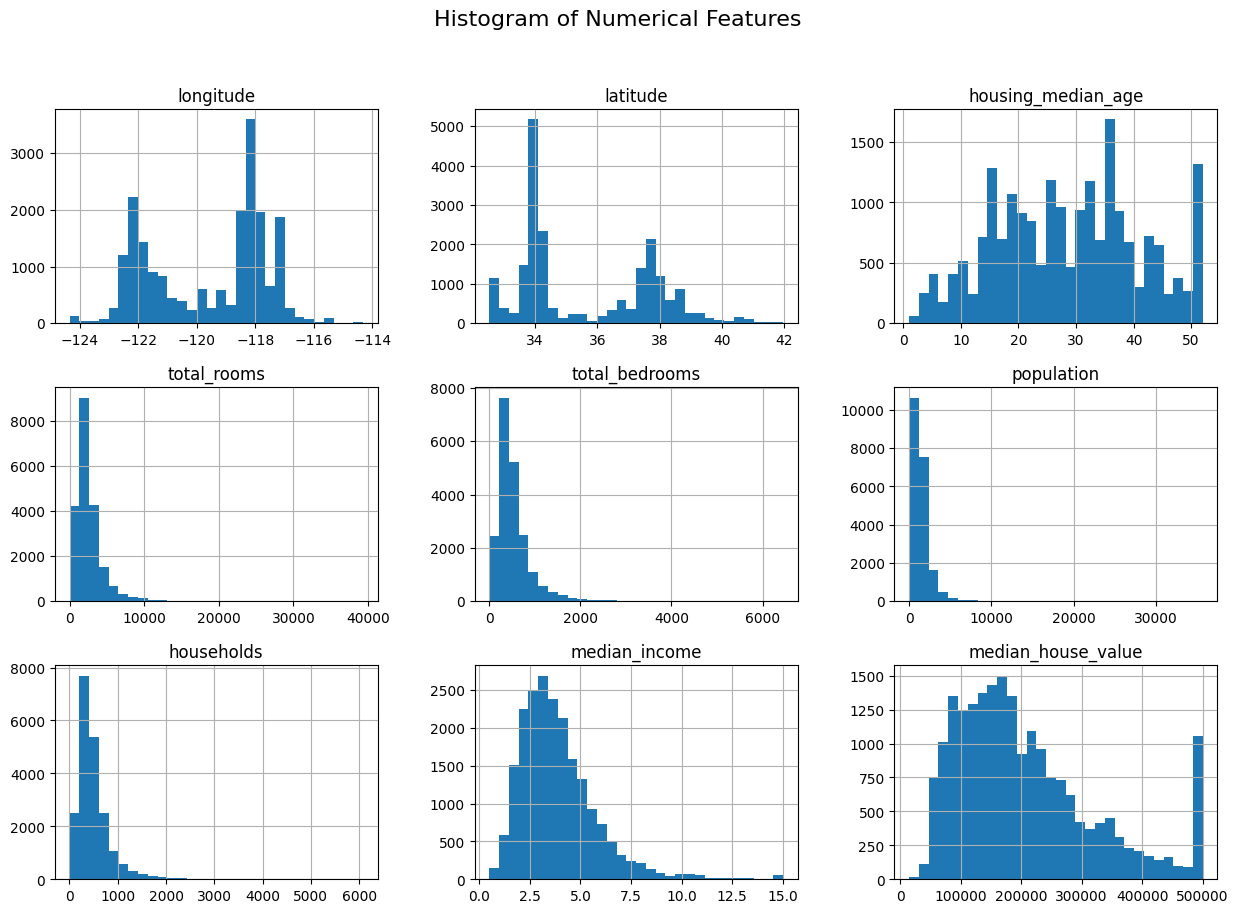

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [21]:
import matplotlib.pyplot as plt

# Descriptive statistics for numerical features
numerical_features = housing_data.select_dtypes(include=['float64', 'int64'])
describe_stats = numerical_features.describe()

# Generating histograms for all numerical features
numerical_features.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram of Numerical Features', fontsize=16)
plt.show()

from IPython.display import display
display(describe_stats)



In [22]:
# Creating new features as described in question c
housing_data['rooms_per_household'] = housing_data['total_rooms'] / housing_data['households']
housing_data['bedrooms_per_room'] = housing_data['total_bedrooms'] / housing_data['total_rooms']

# Verifying if the new features were created successfully
new_features = housing_data[['rooms_per_household', 'bedrooms_per_room']].head()
new_features


,rooms_per_household,bedrooms_per_room
0,6.984127,0.146591
1,6.238137,0.155797
2,8.288136,0.129516
3,5.817352,0.184458
4,6.281853,0.172096


In [24]:
# Filtering only numeric columns for correlation computation
numeric_columns = housing_data.select_dtypes(include=['float64', 'int64'])

# Calculating the correlation matrix again
correlation_matrix = numeric_columns.corr()

# Selecting the target variable's correlations and sorting them
correlation_with_target = correlation_matrix['median_house_value'].sort_values(ascending=False)

# Top 5 features most correlated with the target variable
top_5_correlations = correlation_with_target[1:6]  # Exclude the target itself

# Displaying the results
top_5_correlations


median_income          0.688075
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
Name: median_house_value, dtype: float64

In [27]:
# Importing numpy to ensure np is defined
import numpy as np

# Recreating the 'income_cat' column for stratification
housing_data['income_cat'] = pd.cut(
    housing_data['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
    labels=[1, 2, 3, 4, 5]
)

# Verifying the creation of the 'income_cat' column
income_cat_distribution = housing_data['income_cat'].value_counts()

# Display the distribution of the new feature
income_cat_distribution


income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Performing stratified train-test split using the income_cat column
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

# Verifying the stratification in the train and test sets
train_income_cat_distribution = strat_train_set['income_cat'].value_counts(normalize=True)
test_income_cat_distribution = strat_test_set['income_cat'].value_counts(normalize=True)

# Displaying the distribution for validation
(train_income_cat_distribution, test_income_cat_distribution)


(income_cat
 3    0.350594
 2    0.318859
 4    0.176296
 5    0.114462
 1    0.039789
 Name: proportion, dtype: float64,
 income_cat
 3    0.350533
 2    0.318798
 4    0.176357
 5    0.114341
 1    0.039971
 Name: proportion, dtype: float64)

In [29]:
from sklearn.impute import SimpleImputer

# Creating an imputer to fill missing values with the mean
imputer = SimpleImputer(strategy="mean")

# Applying the imputer to the training data (excluding non-numerical columns)
numerical_columns = strat_train_set.select_dtypes(include=['float64', 'int64']).columns
strat_train_set[numerical_columns] = imputer.fit_transform(strat_train_set[numerical_columns])
strat_test_set[numerical_columns] = imputer.transform(strat_test_set[numerical_columns])

# Verifying if there are any missing values left
missing_values_train = strat_train_set.isnull().sum()
missing_values_test = strat_test_set.isnull().sum()

# Displaying the results
(missing_values_train, missing_values_test)


(longitude              0
 latitude               0
 housing_median_age     0
 total_rooms            0
 total_bedrooms         0
 population             0
 households             0
 median_income          0
 median_house_value     0
 ocean_proximity        0
 rooms_per_household    0
 bedrooms_per_room      0
 income_cat             0
 dtype: int64,
 longitude              0
 latitude               0
 housing_median_age     0
 total_rooms            0
 total_bedrooms         0
 population             0
 households             0
 median_income          0
 median_house_value     0
 ocean_proximity        0
 rooms_per_household    0
 bedrooms_per_room      0
 income_cat             0
 dtype: int64)

In [30]:
from sklearn.preprocessing import StandardScaler

# Creating a scaler for standardizing numerical columns
scaler = StandardScaler()

# Applying the scaler to the numerical columns
strat_train_set[numerical_columns] = scaler.fit_transform(strat_train_set[numerical_columns])
strat_test_set[numerical_columns] = scaler.transform(strat_test_set[numerical_columns])

# Verifying the standardization by checking the mean and std deviation of train set
standardization_check = strat_train_set[numerical_columns].agg(['mean', 'std'])

# Displaying the results
standardization_check


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room
mean,-5.249246e-15,2.811597e-16,8.778508e-17,-1.549148e-17,-1.506117e-16,6.454785e-19,-1.054282e-17,1.148414e-16,6.949652e-17,-6.949652e-17,3.078932e-16
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00


In [31]:
from sklearn.preprocessing import OrdinalEncoder

# Creating an OrdinalEncoder for the ocean_proximity column
ordinal_encoder = OrdinalEncoder(categories=[['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']])

# Applying the encoder to the training and test sets
strat_train_set['ocean_proximity'] = ordinal_encoder.fit_transform(strat_train_set[['ocean_proximity']])
strat_test_set['ocean_proximity'] = ordinal_encoder.transform(strat_test_set[['ocean_proximity']])

# Verifying the encoding
encoded_values_train = strat_train_set['ocean_proximity'].value_counts()
encoded_values_test = strat_test_set['ocean_proximity'].value_counts()

# Displaying the results
(encoded_values_train, encoded_values_test)


(ocean_proximity
 1.0    7277
 0.0    5262
 2.0    2124
 3.0    1847
 4.0       2
 Name: count, dtype: int64,
 ocean_proximity
 1.0    1859
 0.0    1289
 2.0     534
 3.0     443
 4.0       3
 Name: count, dtype: int64)

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Defining the columns
numerical_features = list(numerical_columns)
categorical_features = ['ocean_proximity']

# Creating a preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']]))
])

# Combining pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Verifying the pipeline structure
preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income',
                                  'median_house_value', 'rooms_per_household',
                                  'bedrooms_per_room']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['INLAND',
                                                                              '<1H '
                                                                              'OCEAN',
                                                                              'NEAR '
                                                                              'OCEAN',
                                                                              'NEAR '
                                                                              'BAY',
                                                                              'ISLAND']]))]),
                                 ['ocean_proximity'])])

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Step 1: Feature Engineering
housing_data['rooms_per_household'] = housing_data['total_rooms'] / housing_data['households']
housing_data['bedrooms_per_room'] = housing_data['total_bedrooms'] / housing_data['total_rooms']
housing_data['income_cat'] = pd.cut(
    housing_data['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6, np.inf],
    labels=[1, 2, 3, 4, 5]
)

# Step 2: Stratified Split
strat_train_set, strat_test_set = train_test_split(
    housing_data, test_size=0.2, stratify=housing_data['income_cat'], random_state=42
)
strat_train_set = strat_train_set.drop(columns=['income_cat'])
strat_test_set = strat_test_set.drop(columns=['income_cat'])

# Separating features and target
X_train = strat_train_set.drop(columns=['median_house_value'])
y_train = strat_train_set['median_house_value']
X_test = strat_test_set.drop(columns=['median_house_value'])
y_test = strat_test_set['median_house_value']

# Step 3: Preprocessing Pipelines
numerical_features = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population', 'households', 'median_income',
    'rooms_per_household', 'bedrooms_per_room'
]
categorical_features = ['ocean_proximity']

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']]))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Step 4: Transform the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Step 5: Model Training with Grid Search
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

param_grids = {
    'LinearRegression': {},
    'DecisionTree': {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    }
}

# Running GridSearchCV for each model
best_estimators = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_processed, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

best_estimators


Training LinearRegression...
Best parameters for LinearRegression: {}
Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 10, 'min_samples_split': 10}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


{'LinearRegression': LinearRegression(),
 'DecisionTree': DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42),
 'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42)}

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Evaluate the best models on the test set
results = {}
for model_name, model in best_estimators.items():
    # Making predictions on the test set
    predictions = model.predict(X_test_processed)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    results[model_name] = rmse

# Displaying the results
print(results)


{'LinearRegression': np.float64(67423.78068805729), 'DecisionTree': np.float64(62587.54132813408), 'RandomForest': np.float64(47731.183122726776)}


In [36]:
import joblib

# Save the Linear Regression model
joblib.dump(best_estimators['LinearRegression'], 'linear_regression_model.pkl')
print("Linear Regression model saved as 'linear_regression_model.pkl'")


Linear Regression model saved as 'linear_regression_model.pkl'
